In [1]:
import os
import re
import numpy as np
import pandas as pd
import dask.array as da
import matplotlib.pyplot as plt
import tifffile
from aicsimageio import AICSImage
from cellpose import models
import napari

In [2]:
# relabel labels to be numbered consecutively
def relabel(mask):
    uniques = np.unique(mask)
    for new, old in enumerate(uniques):
        mask[mask==old] = new
    return mask

# 230926_dataset_with_SPY-DNA_for_segmentation

## IO

In [3]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\230926_dataset_with_SPY-DNA_for_segmentation\Raw_data\With dye.lif'

In [4]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [5]:
scenes = lif_img.scenes
scenes

('With dye 619 nm',
 'With dye 619 nm/FLIM/Pattern Matching Scatter Plot Channel 1',
 'With dye 619 nm/FLIM/Intensity',
 'With dye 619 nm/FLIM/Fast Flim',
 'With dye 619 nm/FLIM/Standard Deviation',
 'With dye 630 nm',
 'With dye 630 nm/FLIM/Pattern Matching Scatter Plot Channel 1',
 'With dye 630 nm/FLIM/Intensity',
 'With dye 630 nm/FLIM/Fast Flim',
 'With dye 630 nm/FLIM/Standard Deviation',
 'With dye 635 nm ex',
 'With dye 635 nm ex/FLIM/Pattern Matching Scatter Plot Channel 1',
 'With dye 635 nm ex/FLIM/Intensity',
 'With dye 635 nm ex/FLIM/Fast Flim',
 'With dye 635 nm ex/FLIM/Standard Deviation',
 '30 min_1_635 nm',
 '30 min_1_635 nm/FLIM/Pattern Matching Scatter Plot Channel 1',
 '30 min_1_635 nm/FLIM/Intensity',
 '30 min_1_635 nm/FLIM/Fast Flim',
 '30 min_1_635 nm/FLIM/Standard Deviation',
 '30 min_2_635 nm',
 '30 min_2_635 nm/FLIM/Pattern Matching Scatter Plot Channel 1',
 '30 min_2_635 nm/FLIM/Intensity',
 '30 min_2_635 nm/FLIM/Fast Flim',
 '30 min_2_635 nm/FLIM/Standard De

In [6]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [7]:
items = parse_scenes(scenes)
items

[[0, 'With dye 619 nm'],
 [5, 'With dye 630 nm'],
 [10, 'With dye 635 nm ex'],
 [15, '30 min_1_635 nm'],
 [20, '30 min_2_635 nm'],
 [25, '30 min_3_635 nm']]

In [8]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [9]:
scene_data

dask.array<getitem, shape=(6, 4, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

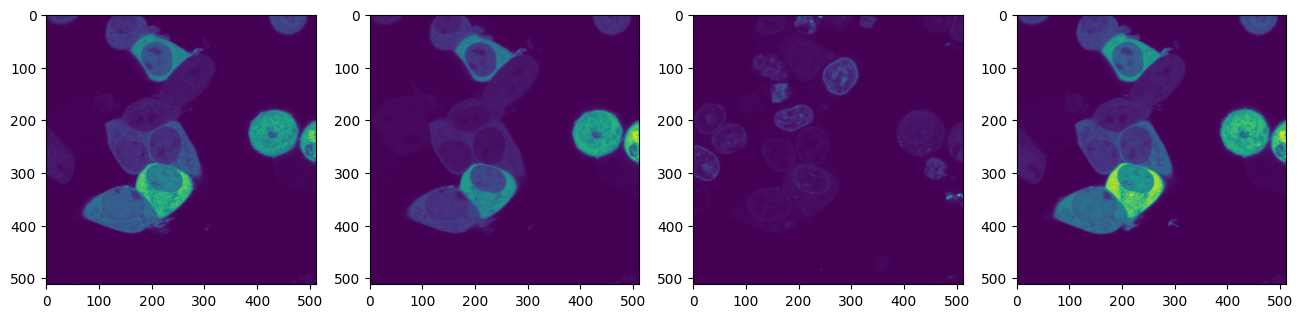

In [17]:
im_no = 0
fig, axs = plt.subplots(1, scene_data.shape[1], figsize=(4*scene_data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(scene_data[im_no,i])

In [18]:
data = da.stack([scene_data[:,2], scene_data[:,0]+scene_data[:,1]], axis=1).astype(float)

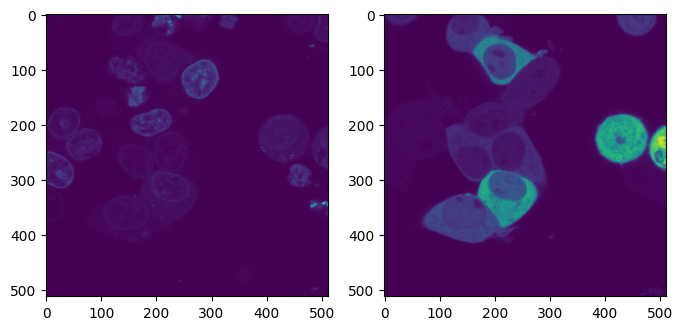

In [19]:
im_no = 0
fig, axs = plt.subplots(1, 2, figsize=(4*2,4))
axs[0].imshow(data[im_no,0])
axs[1].imshow(data[im_no,1])

## cellpose

In [20]:
%%time
data_cp = [im for im in data.compute()]

CPU times: total: 2.48 s
Wall time: 2.36 s


### nuclei

In [21]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 8.92 s
Wall time: 27.4 s


### cells

In [22]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell = np.stack(masks_cell)

CPU times: total: 3.67 s
Wall time: 4.34 s


In [23]:
viewer = napari.Viewer()
viewer.add_image(scene_data, channel_axis = 1)
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell)

<Labels layer 'masks_cell' at 0x1cb8c08f710>

# 231109_dataset_with_SPY595DNA_and_SirActin

## IO

In [3]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\231109_dataset_with_SPY595DNA_and_SirActin\Stable cell line expressing biosensor.lif'

In [4]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [5]:
scenes = lif_img.scenes
scenes

('Unstimulated/D2 Position1',
 'Unstimulated/D2 Position1/FLIM/Intensity',
 'Unstimulated/D2 Position1/FLIM/Fast Flim',
 'Unstimulated/D2 Position1/FLIM/Standard Deviation',
 'Unstimulated/D2 Position1/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D2 Position2',
 'Unstimulated/D2 Position2/FLIM/Intensity',
 'Unstimulated/D2 Position2/FLIM/Fast Flim',
 'Unstimulated/D2 Position2/FLIM/Standard Deviation',
 'Unstimulated/D2 Position2/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D2 Position3',
 'Unstimulated/D2 Position3/FLIM/Intensity',
 'Unstimulated/D2 Position3/FLIM/Fast Flim',
 'Unstimulated/D2 Position3/FLIM/Standard Deviation',
 'Unstimulated/D2 Position3/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D2 Position4',
 'Unstimulated/D2 Position4/FLIM/Intensity',
 'Unstimulated/D2 Position4/FLIM/Fast Flim',
 'Unstimulated/D2 Position4/FLIM/Standard Deviation',
 'Unstimulated/D2 Position4/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Un

In [6]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [7]:
items = parse_scenes(scenes)
items

[[0, 'Unstimulated/D2 Position1'],
 [5, 'Unstimulated/D2 Position2'],
 [10, 'Unstimulated/D2 Position3'],
 [15, 'Unstimulated/D2 Position4'],
 [20, 'Unstimulated/D2 Position5'],
 [25, 'IL-2/D2 Position1'],
 [30, 'IL-2/D2 Position2'],
 [35, 'IL-2/D2 Position3'],
 [40, 'IL-2/D2 Position4'],
 [45, 'IL-2/D2 Position5'],
 [50, 'IL-2/D2 Position6'],
 [55, 'IL-2/D2 Position7'],
 [60, 'IL-2/D2 Position8']]

In [8]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [9]:
scene_data

dask.array<getitem, shape=(13, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

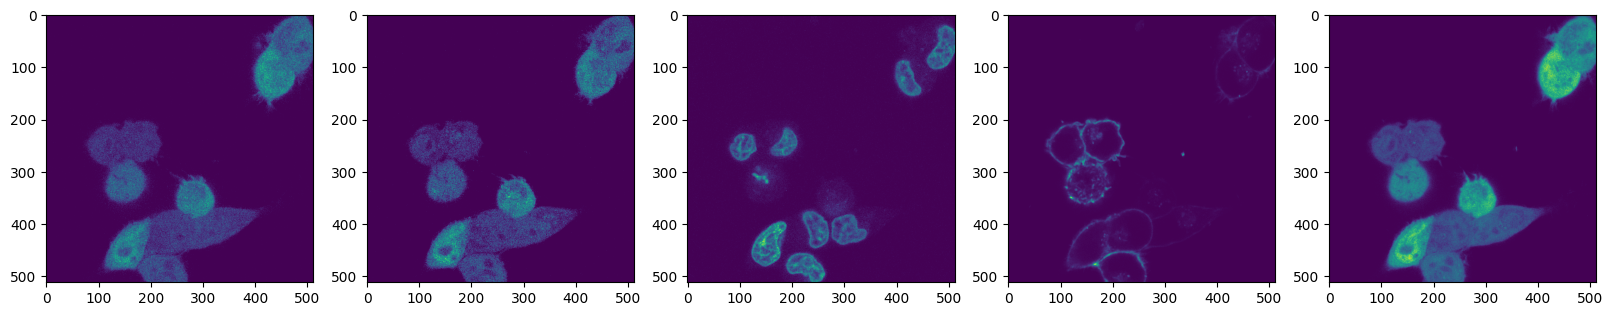

In [10]:
im_no = 3
fig, axs = plt.subplots(1, scene_data.shape[1], figsize=(4*scene_data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(scene_data[im_no,i])

1: nuclei  
2: norm(A) + norm(D)  
3: actin  
4: norm(A) + norm(D) + 2 * norm(actin)  
5: norm(A) + norm(D) - 2 * norm(actin)  

In [11]:
def normalize(img, percentages=(1,99)):
    percentiles = np.percentile(img, percentages)
    out = (img.astype(float) - percentiles[0]) / (percentiles[1] - percentiles[0])
    return out
def combine(cyx_img):
    img_nuc = cyx_img[2]
    img_A = cyx_img[0]
    img_D = cyx_img[1]
    img_act = cyx_img[3]
    img_A_norm = normalize(img_A)
    img_D_norm = normalize(img_D)
    img_act_norm = normalize(img_act)
    return np.stack([
        normalize(img_nuc),
        normalize(img_A_norm + img_D_norm),
        normalize(img_act),
        normalize(img_A_norm + img_D_norm + 2*img_act_norm),
        img_A_norm + img_D_norm - 2*img_act_norm,
    ], axis=0)

In [12]:
scene_data_comp = scene_data.compute()

In [13]:
data = np.stack([combine(cyx_img) for cyx_img in scene_data_comp], axis=0)

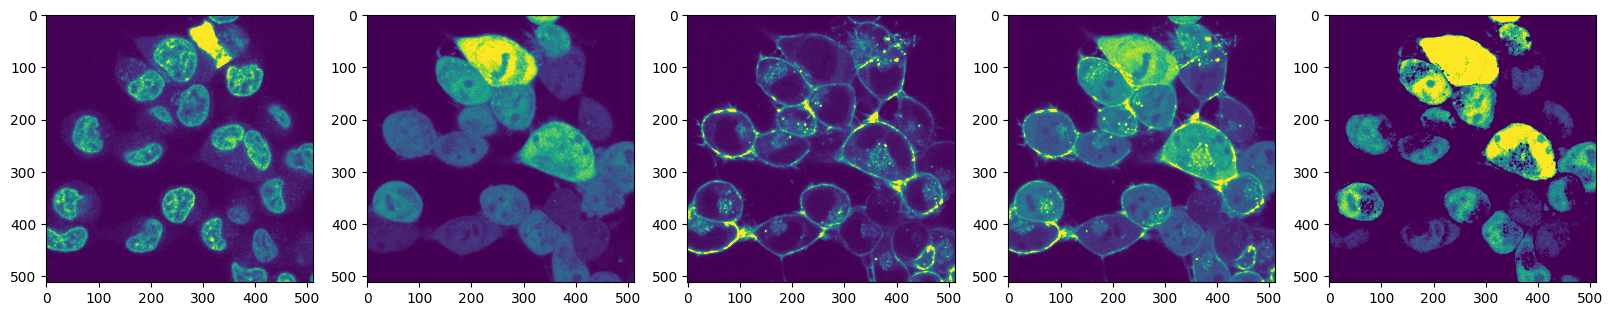

In [14]:
im_no = 0
fig, axs = plt.subplots(1, data.shape[1], figsize=(4*data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(data[im_no,i], vmin=0, vmax=1)

## cellpose

In [15]:
%%time
data_cp = [im for im in data]

CPU times: total: 0 ns
Wall time: 0 ns


### nuclei

In [16]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

C:\ProgramData\MinicondaZMB\envs\zmb_21\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


CPU times: total: 6.08 s
Wall time: 6.26 s


### cells

#### A+D

In [17]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_2 = np.stack(masks_cell)

CPU times: total: 6.09 s
Wall time: 5.73 s


#### actin

In [18]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[3,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_3 = np.stack(masks_cell)

CPU times: total: 6.05 s
Wall time: 5.73 s


#### A + D + 2*actin

In [19]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[4,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_4 = np.stack(masks_cell)

CPU times: total: 5.95 s
Wall time: 5.77 s


#### A + D - 2*actin

In [20]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[5,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_5 = np.stack(masks_cell)

CPU times: total: 5.83 s
Wall time: 5.67 s


In [21]:
viewer = napari.Viewer()
viewer.add_image(data, channel_axis = 1, contrast_limits=[0,1])
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell_2)
viewer.add_labels(masks_cell_3)
viewer.add_labels(masks_cell_4)
viewer.add_labels(masks_cell_5)

<Labels layer 'masks_cell_5' at 0x1e713f98fd0>

Results:
Slight improvement with A+D+2*actin over A+D, but probably not worth it

# 240209_datasetwithbothdyes_beforeandafterstimulation

## IO

In [22]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\240209_datasetwithbothdyes_beforeandafterstimulation\Transduced cell line with dyes.lif'

In [23]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [24]:
scenes = lif_img.scenes
scenes

('Unstimulated/D3 Position1',
 'Unstimulated/D3 Position1/FLIM/Intensity',
 'Unstimulated/D3 Position1/FLIM/Fast Flim',
 'Unstimulated/D3 Position1/FLIM/Standard Deviation',
 'Unstimulated/D3 Position1/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D3 Position2',
 'Unstimulated/D3 Position2/FLIM/Intensity',
 'Unstimulated/D3 Position2/FLIM/Fast Flim',
 'Unstimulated/D3 Position2/FLIM/Standard Deviation',
 'Unstimulated/D3 Position2/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D3 Position3',
 'Unstimulated/D3 Position3/FLIM/Intensity',
 'Unstimulated/D3 Position3/FLIM/Fast Flim',
 'Unstimulated/D3 Position3/FLIM/Standard Deviation',
 'Unstimulated/D3 Position3/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D3 Position4',
 'Unstimulated/D3 Position4/FLIM/Intensity',
 'Unstimulated/D3 Position4/FLIM/Fast Flim',
 'Unstimulated/D3 Position4/FLIM/Standard Deviation',
 'Unstimulated/D3 Position4/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Un

In [25]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [26]:
items = parse_scenes(scenes)
items

[[0, 'Unstimulated/D3 Position1'],
 [5, 'Unstimulated/D3 Position2'],
 [10, 'Unstimulated/D3 Position3'],
 [15, 'Unstimulated/D3 Position4'],
 [20, 'Unstimulated/D3 Position5'],
 [25, 'Unstimulated/D3 Position6'],
 [30, 'Unstimulated/D3 Position7'],
 [35, 'Unstimulated/D3 Position8'],
 [40, 'IL-2_stimulated/D3 Position1'],
 [45, 'IL-2_stimulated/D3 Position2'],
 [50, 'IL-2_stimulated/D3 Position3'],
 [55, 'IL-2_stimulated/D3 Position4'],
 [60, 'IL-2_stimulated/D3 Position5'],
 [65, 'IL-2_stimulated/D3 Position6'],
 [70, 'IL-2_stimulated/D3 Position7'],
 [75, 'IL-2_stimulated/D3 Position8']]

In [27]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [28]:
scene_data

dask.array<getitem, shape=(16, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

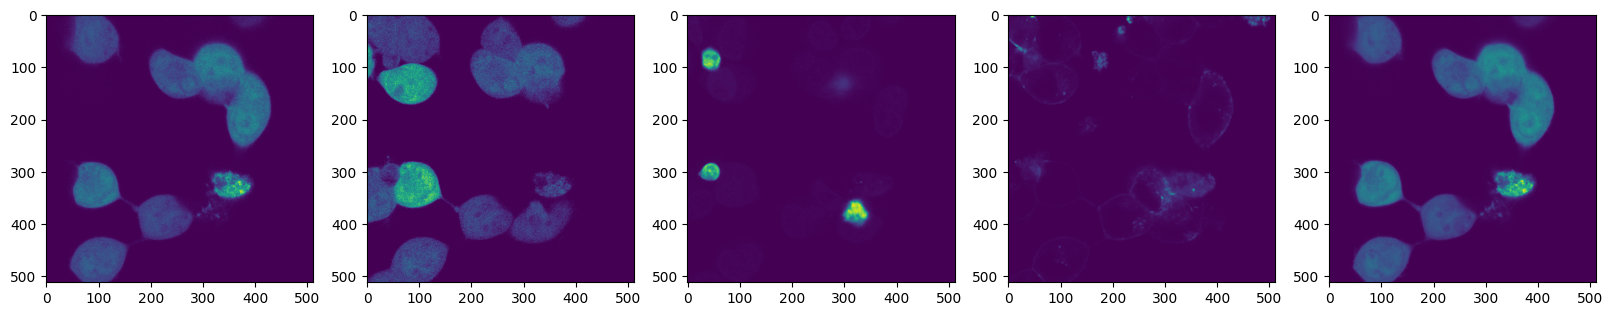

In [29]:
im_no = 3
fig, axs = plt.subplots(1, scene_data.shape[1], figsize=(4*scene_data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(scene_data[im_no,i])

1: nuclei  
2: norm(A) + norm(D)  
3: actin  
4: norm(A) + norm(D) + 2 * norm(actin)  
5: norm(A) + norm(D) - 2 * norm(actin)  

In [30]:
def normalize(img, percentages=(1,99)):
    percentiles = np.percentile(img, percentages)
    out = (img.astype(float) - percentiles[0]) / (percentiles[1] - percentiles[0])
    return out
def combine(cyx_img):
    img_nuc = cyx_img[2]
    img_A = cyx_img[0]
    img_D = cyx_img[1]
    img_act = cyx_img[3]
    img_A_norm = normalize(img_A)
    img_D_norm = normalize(img_D)
    img_act_norm = normalize(img_act)
    return np.stack([
        normalize(img_nuc),
        normalize(img_A_norm + img_D_norm),
        normalize(img_act),
        normalize(img_A_norm + img_D_norm + 2*img_act_norm),
        img_A_norm + img_D_norm - 2*img_act_norm,
    ], axis=0)

In [31]:
scene_data_comp = scene_data.compute()

In [32]:
data = np.stack([combine(cyx_img) for cyx_img in scene_data_comp], axis=0)

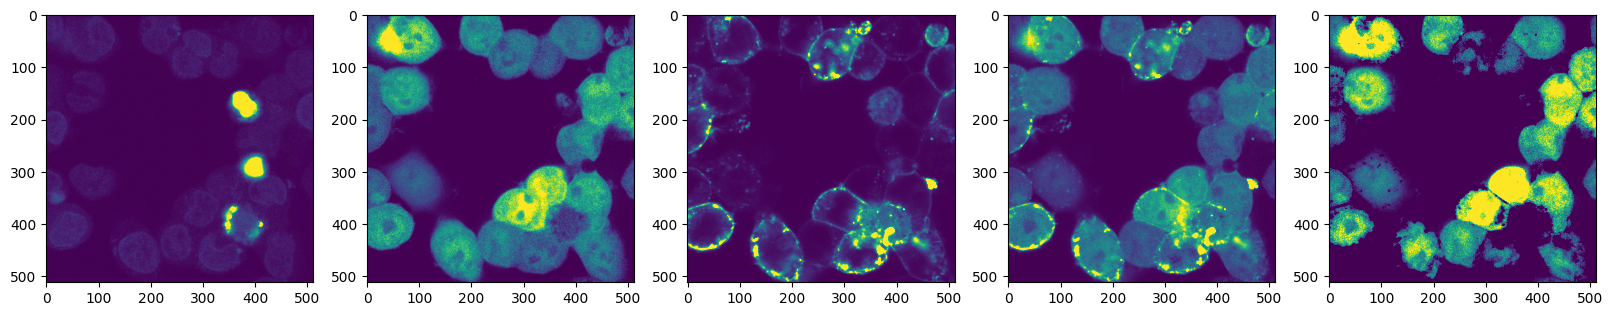

In [33]:
im_no = 0
fig, axs = plt.subplots(1, data.shape[1], figsize=(4*data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(data[im_no,i], vmin=0, vmax=1)

## cellpose

In [34]:
%%time
data_cp = [im for im in data]

CPU times: total: 0 ns
Wall time: 0 ns


### nuclei

In [35]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 6.56 s
Wall time: 6.56 s


### cells

#### A+D

In [36]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_2 = np.stack(masks_cell)

CPU times: total: 7.34 s
Wall time: 7.16 s


#### actin

In [37]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[3,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_3 = np.stack(masks_cell)

CPU times: total: 7.02 s
Wall time: 7.01 s


#### A + D + 2*actin

In [38]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[4,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_4 = np.stack(masks_cell)

CPU times: total: 7.61 s
Wall time: 7.35 s


#### A + D - 2*actin

In [39]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[5,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_5 = np.stack(masks_cell)

CPU times: total: 7.25 s
Wall time: 7.1 s


In [40]:
viewer = napari.Viewer()
viewer.add_image(data, channel_axis = 1, contrast_limits=[0,1])
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell_2)
viewer.add_labels(masks_cell_3)
viewer.add_labels(masks_cell_4)
viewer.add_labels(masks_cell_5)

<Labels layer 'masks_cell_5' at 0x1e76dd03d90>

Results:  
Slight improvement with A+D+2*actin over A+D, maybe worth it

# 240216_dataset20x_bothdyes_beforeandafter

## IO

In [41]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\240216_dataset20x_bothdyes_beforeandafter\Transduced cells 20x test.lif'

In [42]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [43]:
scenes = lif_img.scenes
scenes

('Unstimulated/D/2/R1',
 'Unstimulated/D/2/R1/FLIM/Intensity',
 'Unstimulated/D/2/R1/FLIM/Fast Flim',
 'Unstimulated/D/2/R1/FLIM/Standard Deviation',
 'Unstimulated/D/2/R1/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D/2/R2',
 'Unstimulated/D/2/R2/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D/2/R2/FLIM/Intensity',
 'Unstimulated/D/2/R2/FLIM/Fast Flim',
 'Unstimulated/D/2/R2/FLIM/Standard Deviation',
 'Unstimulated/D/2/R3',
 'Unstimulated/D/2/R3/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D/2/R3/FLIM/Intensity',
 'Unstimulated/D/2/R3/FLIM/Fast Flim',
 'Unstimulated/D/2/R3/FLIM/Standard Deviation',
 'Unstimulated/D/2/R4',
 'Unstimulated/D/2/R4/FLIM/Intensity',
 'Unstimulated/D/2/R4/FLIM/Fast Flim',
 'Unstimulated/D/2/R4/FLIM/Standard Deviation',
 'Unstimulated/D/2/R4/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D/2/R5',
 'Unstimulated/D/2/R5/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D/2/R5/FLIM/Inte

In [44]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [45]:
items = parse_scenes(scenes)
items

[[0, 'Unstimulated/D/2/R1'],
 [5, 'Unstimulated/D/2/R2'],
 [10, 'Unstimulated/D/2/R3'],
 [15, 'Unstimulated/D/2/R4'],
 [20, 'Unstimulated/D/2/R5'],
 [25, 'Unstimulated/D/2/R6'],
 [30, 'Unstimulated/D/3/R1'],
 [35, 'Unstimulated/D/3/R2'],
 [40, 'Unstimulated/D/3/R3'],
 [45, 'Unstimulated/D/3/R4'],
 [50, 'Unstimulated/D/3/R5'],
 [55, 'Unstimulated/D/3/R6'],
 [60, 'Unstimulated/D/4/R1'],
 [65, 'Unstimulated/D/4/R2'],
 [70, 'Unstimulated/D/4/R3'],
 [75, 'Unstimulated/D/4/R4'],
 [80, 'Unstimulated/D/4/R5'],
 [85, 'Unstimulated/D/4/R6'],
 [90, 'IL-2/D/2/R1'],
 [95, 'IL-2/D/2/R2'],
 [100, 'IL-2/D/2/R3'],
 [105, 'IL-2/D/2/R4'],
 [110, 'IL-2/D/2/R5'],
 [115, 'IL-2/D/2/R6'],
 [120, 'IL-2/D/3/R1'],
 [125, 'IL-2/D/3/R2'],
 [130, 'IL-2/D/3/R3'],
 [135, 'IL-2/D/3/R4'],
 [140, 'IL-2/D/3/R5'],
 [145, 'IL-2/D/3/R6'],
 [150, 'IL-2/D/4/R1'],
 [155, 'IL-2/D/4/R2'],
 [160, 'IL-2/D/4/R3'],
 [165, 'IL-2/D/4/R4'],
 [170, 'IL-2/D/4/R5'],
 [175, 'IL-2/D/4/R6']]

In [46]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [47]:
scene_data

dask.array<getitem, shape=(36, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

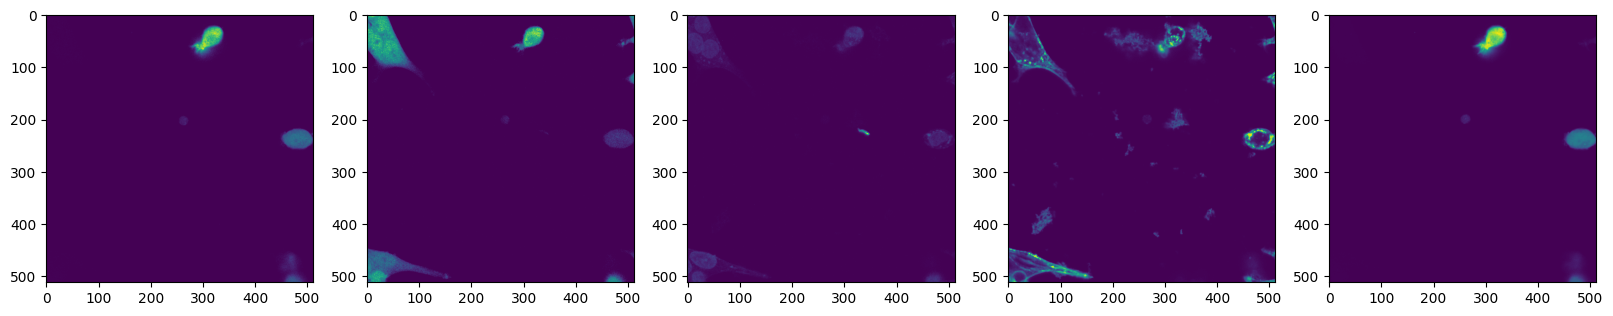

In [48]:
im_no = 3
fig, axs = plt.subplots(1, scene_data.shape[1], figsize=(4*scene_data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(scene_data[im_no,i])

1: nuclei  
2: norm(A) + norm(D)  
3: actin  
4: norm(A) + norm(D) + 2 * norm(actin)  
5: norm(A) + norm(D) - 2 * norm(actin)  

In [49]:
def normalize(img, percentages=(1,99)):
    percentiles = np.percentile(img, percentages)
    out = (img.astype(float) - percentiles[0]) / (percentiles[1] - percentiles[0])
    return out
def combine(cyx_img):
    img_nuc = cyx_img[2]
    img_A = cyx_img[0]
    img_D = cyx_img[1]
    img_act = cyx_img[3]
    img_A_norm = normalize(img_A)
    img_D_norm = normalize(img_D)
    img_act_norm = normalize(img_act)
    return np.stack([
        normalize(img_nuc),
        normalize(img_A_norm + img_D_norm),
        normalize(img_act),
        normalize(img_A_norm + img_D_norm + 2*img_act_norm),
        img_A_norm + img_D_norm - 2*img_act_norm,
    ], axis=0)

In [50]:
scene_data_comp = scene_data.compute()

In [51]:
data = np.stack([combine(cyx_img) for cyx_img in scene_data_comp], axis=0)

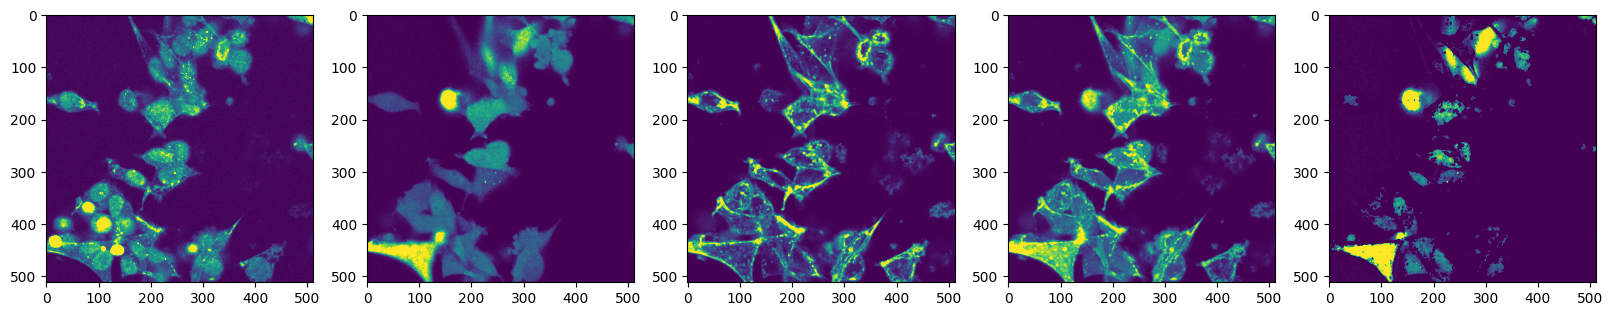

In [52]:
im_no = 0
fig, axs = plt.subplots(1, data.shape[1], figsize=(4*data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(data[im_no,i], vmin=0, vmax=1)

## cellpose

In [53]:
%%time
data_cp = [im for im in data]

CPU times: total: 0 ns
Wall time: 0 ns


### nuclei

In [54]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 14 s
Wall time: 13.8 s


### cells

#### A+D

In [55]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_2 = np.stack(masks_cell)

CPU times: total: 14.5 s
Wall time: 14.4 s


#### actin

In [56]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[3,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_3 = np.stack(masks_cell)

CPU times: total: 14.9 s
Wall time: 14.5 s


#### A + D + 2*actin

In [57]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[4,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_4 = np.stack(masks_cell)

CPU times: total: 15.3 s
Wall time: 14.5 s


#### A + D - 2*actin

In [58]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[5,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_5 = np.stack(masks_cell)

CPU times: total: 14.5 s
Wall time: 14 s


In [59]:
viewer = napari.Viewer()
viewer.add_image(data, channel_axis = 1, contrast_limits=[0,1])
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell_2)
viewer.add_labels(masks_cell_3)
viewer.add_labels(masks_cell_4)
viewer.add_labels(masks_cell_5)

<Labels layer 'masks_cell_5' at 0x1e7892d47d0>

Results:  
Segmentation overall is bad.
actin sometimes helps and sometimes not, but not by much

# 240503_dataset_SPY-DNA-titration - Transduced cell line with dyes stimulated 20x.lif

## IO

In [61]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\240503_dataset_SPY-DNA-titration/Transduced cell line with dyes stimulated 20x.lif'

In [62]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [63]:
scenes = lif_img.scenes
scenes

('Stimulated 20x/B/2/R1',
 'Stimulated 20x/B/2/R1/FLIM/Intensity',
 'Stimulated 20x/B/2/R1/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R1/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R1/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R2',
 'Stimulated 20x/B/2/R2/FLIM/Intensity',
 'Stimulated 20x/B/2/R2/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R2/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R2/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R3',
 'Stimulated 20x/B/2/R3/FLIM/Intensity',
 'Stimulated 20x/B/2/R3/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R3/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R3/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R4',
 'Stimulated 20x/B/2/R4/FLIM/Intensity',
 'Stimulated 20x/B/2/R4/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R4/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R4/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R5',
 'Stimulated 20x/B/2/R5/FLIM/Intensity',
 'Stimulated 20x/

In [64]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [65]:
items = parse_scenes(scenes)
items

[[0, 'Stimulated 20x/B/2/R1'],
 [5, 'Stimulated 20x/B/2/R2'],
 [10, 'Stimulated 20x/B/2/R3'],
 [15, 'Stimulated 20x/B/2/R4'],
 [20, 'Stimulated 20x/B/2/R5'],
 [25, 'Stimulated 20x/B/3/R1'],
 [30, 'Stimulated 20x/B/3/R2'],
 [35, 'Stimulated 20x/B/3/R3'],
 [40, 'Stimulated 20x/B/3/R4'],
 [45, 'Stimulated 20x/B/3/R5'],
 [50, 'Stimulated 20x/B/4/R1'],
 [55, 'Stimulated 20x/B/4/R2'],
 [60, 'Stimulated 20x/B/4/R3'],
 [65, 'Stimulated 20x/B/4/R4'],
 [70, 'Stimulated 20x/B/4/R5'],
 [75, 'Stimulated 20x/B/5/R1'],
 [80, 'Stimulated 20x/B/5/R2'],
 [85, 'Stimulated 20x/B/5/R3'],
 [90, 'Stimulated 20x/B/5/R4'],
 [95, 'Stimulated 20x/B/5/R5'],
 [100, 'Stimulated 20x/B/6/R1'],
 [105, 'Stimulated 20x/B/6/R2'],
 [110, 'Stimulated 20x/B/6/R3'],
 [115, 'Stimulated 20x/B/6/R4'],
 [120, 'Stimulated 20x/B/6/R5']]

In [66]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [67]:
scene_data

dask.array<getitem, shape=(25, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

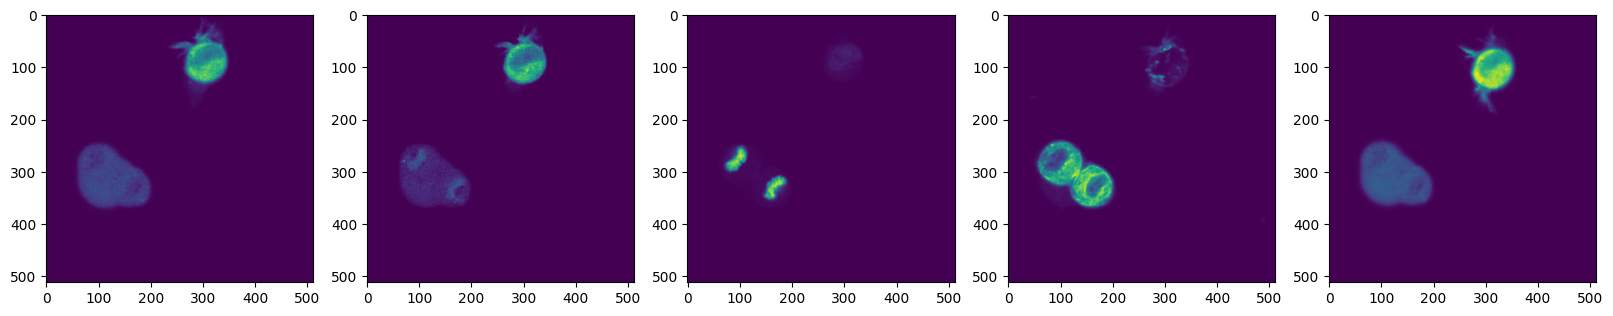

In [68]:
im_no = 3
fig, axs = plt.subplots(1, scene_data.shape[1], figsize=(4*scene_data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(scene_data[im_no,i])

1: nuclei  
2: norm(A) + norm(D)  
3: actin  
4: norm(A) + norm(D) + 2 * norm(actin)  
5: norm(A) + norm(D) - 2 * norm(actin)  

In [69]:
def normalize(img, percentages=(1,99)):
    percentiles = np.percentile(img, percentages)
    out = (img.astype(float) - percentiles[0]) / (percentiles[1] - percentiles[0])
    return out
def combine(cyx_img):
    img_nuc = cyx_img[2]
    img_A = cyx_img[0]
    img_D = cyx_img[1]
    img_act = cyx_img[3]
    img_A_norm = normalize(img_A)
    img_D_norm = normalize(img_D)
    img_act_norm = normalize(img_act)
    return np.stack([
        normalize(img_nuc),
        normalize(img_A_norm + img_D_norm),
        normalize(img_act),
        normalize(img_A_norm + img_D_norm + 2*img_act_norm),
        img_A_norm + img_D_norm - 2*img_act_norm,
    ], axis=0)

In [70]:
scene_data_comp = scene_data.compute()

In [71]:
data = np.stack([combine(cyx_img) for cyx_img in scene_data_comp], axis=0)

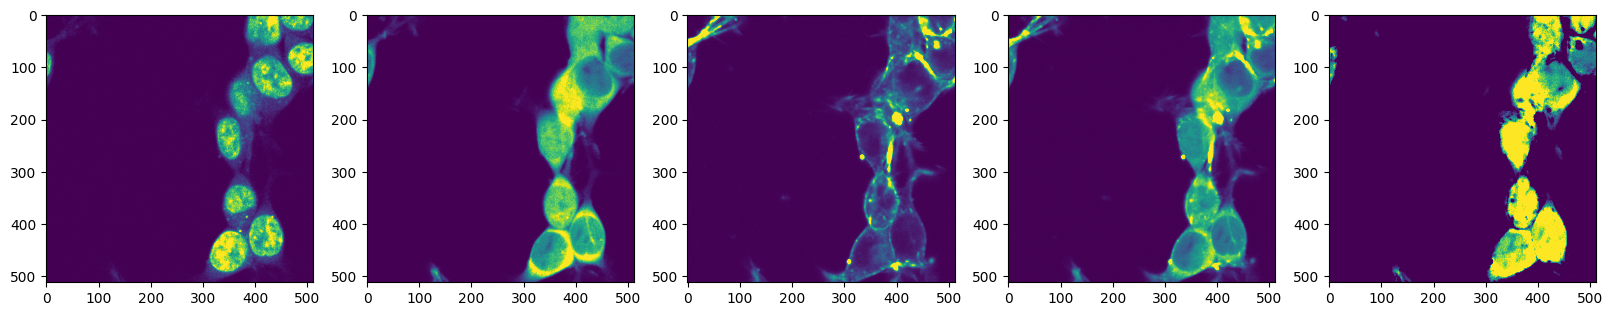

In [72]:
im_no = 0
fig, axs = plt.subplots(1, data.shape[1], figsize=(4*data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(data[im_no,i], vmin=0, vmax=1)

## cellpose

In [73]:
%%time
data_cp = [im for im in data]

CPU times: total: 0 ns
Wall time: 0 ns


### nuclei

In [74]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 10.4 s
Wall time: 9.96 s


### cells

#### A+D

In [75]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_2 = np.stack(masks_cell)

CPU times: total: 9.81 s
Wall time: 9.73 s


#### actin

In [76]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[3,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_3 = np.stack(masks_cell)

CPU times: total: 10.6 s
Wall time: 10.3 s


#### A + D + 2*actin

In [77]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[4,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_4 = np.stack(masks_cell)

CPU times: total: 10.4 s
Wall time: 10.3 s


#### A + D - 2*actin

In [78]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[5,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_5 = np.stack(masks_cell)

CPU times: total: 9.88 s
Wall time: 9.53 s


In [79]:
viewer = napari.Viewer()
viewer.add_image(data, channel_axis = 1, contrast_limits=[0,1])
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell_2)
viewer.add_labels(masks_cell_3)
viewer.add_labels(masks_cell_4)
viewer.add_labels(masks_cell_5)

<Labels layer 'masks_cell_5' at 0x1e7b0186e50>

Results:  
Overall ok segmentation  
Slightly worse with A+D+2*actin over A+D

# 240503_dataset_SPY-DNA-titration - Transduced cell line with dyes stimulated.lif

## IO

In [80]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\240503_dataset_SPY-DNA-titration/Transduced cell line with dyes stimulated.lif'

In [81]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [82]:
scenes = lif_img.scenes
scenes

('1_250_stim/B2 Position1',
 '1_250_stim/B2 Position1/FLIM/Intensity',
 '1_250_stim/B2 Position1/FLIM/Fast Flim',
 '1_250_stim/B2 Position1/FLIM/Standard Deviation',
 '1_250_stim/B2 Position1/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_250_stim/B2 Position2',
 '1_250_stim/B2 Position2/FLIM/Intensity',
 '1_250_stim/B2 Position2/FLIM/Fast Flim',
 '1_250_stim/B2 Position2/FLIM/Standard Deviation',
 '1_250_stim/B2 Position2/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_250_stim/B2 Position3',
 '1_250_stim/B2 Position3/FLIM/Intensity',
 '1_250_stim/B2 Position3/FLIM/Fast Flim',
 '1_250_stim/B2 Position3/FLIM/Standard Deviation',
 '1_250_stim/B2 Position3/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_250_stim/B2 Position4',
 '1_250_stim/B2 Position4/FLIM/Intensity',
 '1_250_stim/B2 Position4/FLIM/Fast Flim',
 '1_250_stim/B2 Position4/FLIM/Standard Deviation',
 '1_250_stim/B2 Position4/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_250_stim/B2 Position5',
 '1_250_stim/B2 

In [83]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [84]:
items = parse_scenes(scenes)
items

[[0, '1_250_stim/B2 Position1'],
 [5, '1_250_stim/B2 Position2'],
 [10, '1_250_stim/B2 Position3'],
 [15, '1_250_stim/B2 Position4'],
 [20, '1_250_stim/B2 Position5'],
 [25, '1_500_stim/B3 Position1'],
 [30, '1_500_stim/B3 Position2'],
 [35, '1_500_stim/B3 Position3'],
 [40, '1_500_stim/B3 Position4'],
 [45, '1_500_stim/B3 Position5'],
 [50, '1_1000_stim/B4 Position1'],
 [55, '1_1000_stim/B4 Position2'],
 [60, '1_1000_stim/B4 Position3'],
 [65, '1_1000_stim/B4 Position4'],
 [70, '1_1000_stim/B4 Position5'],
 [75, '1_2000_stim/B5 Position1'],
 [80, '1_2000_stim/B5 Position2'],
 [85, '1_2000_stim/B5 Position3'],
 [90, '1_2000_stim/B5 Position4'],
 [95, '1_2000_stim/B5 Position5'],
 [100, '1_4000_stim/B6 Position1'],
 [105, '1_4000_stim/B6 Position2'],
 [110, '1_4000_stim/B6 Position3'],
 [115, '1_4000_stim/B6 Position4'],
 [120, '1_4000_stim/B6 Position5']]

In [85]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [86]:
scene_data

dask.array<getitem, shape=(25, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

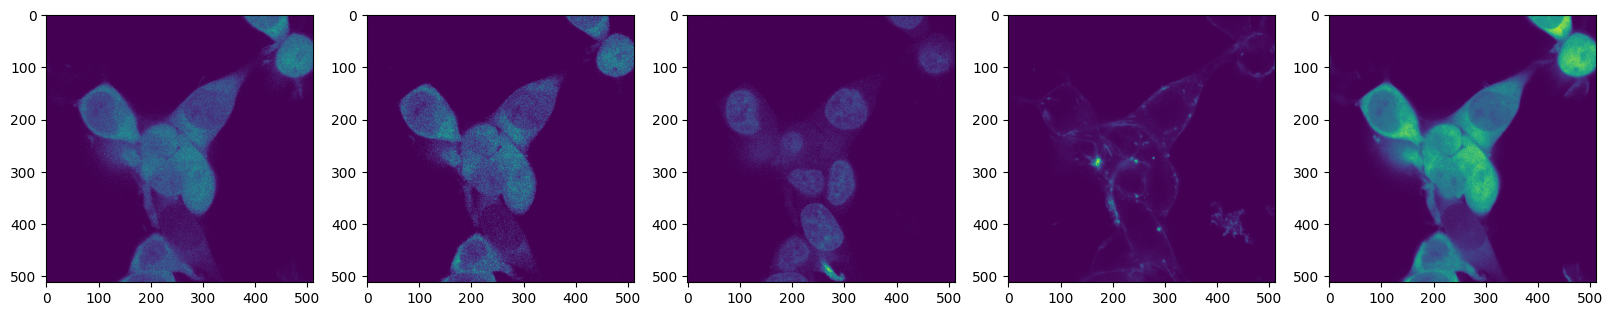

In [87]:
im_no = 3
fig, axs = plt.subplots(1, scene_data.shape[1], figsize=(4*scene_data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(scene_data[im_no,i])

1: nuclei  
2: norm(A) + norm(D)  
3: actin  
4: norm(A) + norm(D) + 2 * norm(actin)  
5: norm(A) + norm(D) - 2 * norm(actin)  

In [88]:
def normalize(img, percentages=(1,99)):
    percentiles = np.percentile(img, percentages)
    out = (img.astype(float) - percentiles[0]) / (percentiles[1] - percentiles[0])
    return out
def combine(cyx_img):
    img_nuc = cyx_img[2]
    img_A = cyx_img[0]
    img_D = cyx_img[1]
    img_act = cyx_img[3]
    img_A_norm = normalize(img_A)
    img_D_norm = normalize(img_D)
    img_act_norm = normalize(img_act)
    return np.stack([
        normalize(img_nuc),
        normalize(img_A_norm + img_D_norm),
        normalize(img_act),
        normalize(img_A_norm + img_D_norm + 2*img_act_norm),
        img_A_norm + img_D_norm - 2*img_act_norm,
    ], axis=0)

In [89]:
scene_data_comp = scene_data.compute()

In [90]:
data = np.stack([combine(cyx_img) for cyx_img in scene_data_comp], axis=0)

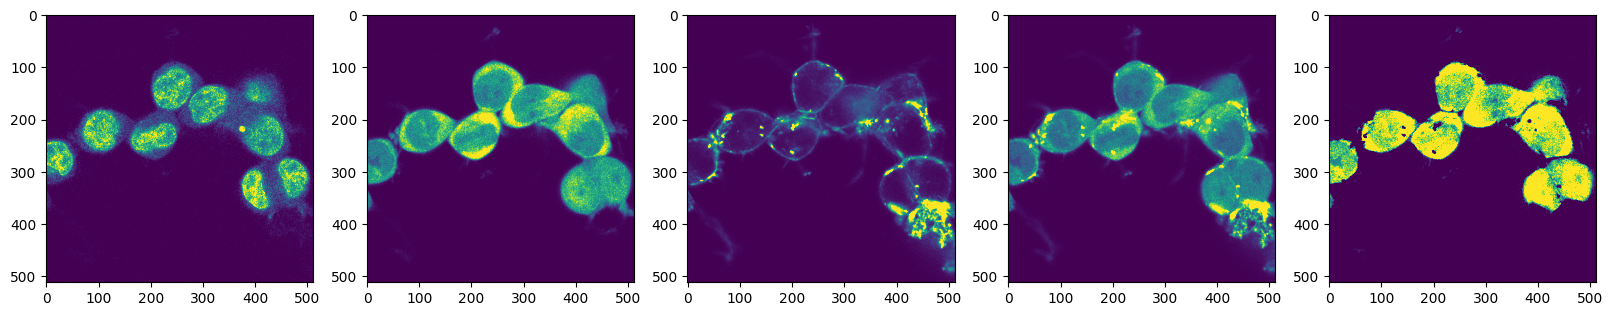

In [91]:
im_no = 0
fig, axs = plt.subplots(1, data.shape[1], figsize=(4*data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(data[im_no,i], vmin=0, vmax=1)

## cellpose

In [92]:
%%time
data_cp = [im for im in data]

CPU times: total: 0 ns
Wall time: 0 ns


### nuclei

In [93]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 11 s
Wall time: 10.7 s


### cells

#### A+D

In [94]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_2 = np.stack(masks_cell)

CPU times: total: 11.4 s
Wall time: 11.1 s


#### actin

In [95]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[3,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_3 = np.stack(masks_cell)

CPU times: total: 11.7 s
Wall time: 11.4 s


#### A + D + 2*actin

In [96]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[4,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_4 = np.stack(masks_cell)

CPU times: total: 11.6 s
Wall time: 11.2 s


#### A + D - 2*actin

In [97]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[5,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_5 = np.stack(masks_cell)

CPU times: total: 12 s
Wall time: 11.4 s


In [98]:
viewer = napari.Viewer()
viewer.add_image(data, channel_axis = 1, contrast_limits=[0,1])
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell_2)
viewer.add_labels(masks_cell_3)
viewer.add_labels(masks_cell_4)
viewer.add_labels(masks_cell_5)

<Labels layer 'masks_cell_5' at 0x1e724155690>

Results:  
Overall ok segmentation  
Actin sometimes helps, sometimes not. Probably not worth it

# 240503_dataset_SPY-DNA-titration - Transduced cell line with dyes unstim.lif

## IO

In [99]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\240503_dataset_SPY-DNA-titration/Transduced cell line with dyes unstim.lif'

In [100]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [101]:
scenes = lif_img.scenes
scenes

('1_250_unstim/B2 Position1',
 '1_250_unstim/B2 Position1/FLIM/Intensity',
 '1_250_unstim/B2 Position1/FLIM/Fast Flim',
 '1_250_unstim/B2 Position1/FLIM/Standard Deviation',
 '1_250_unstim/B2 Position1/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_250_unstim/B2 Position2',
 '1_250_unstim/B2 Position2/FLIM/Intensity',
 '1_250_unstim/B2 Position2/FLIM/Fast Flim',
 '1_250_unstim/B2 Position2/FLIM/Standard Deviation',
 '1_250_unstim/B2 Position2/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_250_unstim/B2 Position3',
 '1_250_unstim/B2 Position3/FLIM/Intensity',
 '1_250_unstim/B2 Position3/FLIM/Fast Flim',
 '1_250_unstim/B2 Position3/FLIM/Standard Deviation',
 '1_250_unstim/B2 Position3/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_250_unstim/B2 Position4',
 '1_250_unstim/B2 Position4/FLIM/Intensity',
 '1_250_unstim/B2 Position4/FLIM/Fast Flim',
 '1_250_unstim/B2 Position4/FLIM/Standard Deviation',
 '1_250_unstim/B2 Position4/FLIM/Pattern Matching Scatter Plot Channel 1',
 '1_

In [102]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [103]:
items = parse_scenes(scenes)
items

[[0, '1_250_unstim/B2 Position1'],
 [5, '1_250_unstim/B2 Position2'],
 [10, '1_250_unstim/B2 Position3'],
 [15, '1_250_unstim/B2 Position4'],
 [20, '1_250_unstim/B2 Position5'],
 [25, '1_500_unstim/B3 Position1'],
 [30, '1_500_unstim/B3 Position2'],
 [35, '1_500_unstim/B3 Position3'],
 [40, '1_500_unstim/B3 Position4'],
 [45, '1_500_unstim/B3 Position5'],
 [50, '1_1000_unstim/B4 Position1'],
 [55, '1_1000_unstim/B4 Position2'],
 [60, '1_1000_unstim/B4 Position3'],
 [65, '1_1000_unstim/B4 Position4'],
 [70, '1_1000_unstim/B4 Position5'],
 [75, '1_2000_unstim/B5 Position1'],
 [80, '1_2000_unstim/B5 Position2'],
 [85, '1_2000_unstim/B5 Position3'],
 [90, '1_2000_unstim/B5 Position4'],
 [95, '1_2000_unstim/B5 Position5'],
 [100, '1_4000 unstim/B6 Position1'],
 [105, '1_4000 unstim/B6 Position2'],
 [110, '1_4000 unstim/B6 Position3'],
 [115, '1_4000 unstim/B6 Position4'],
 [120, '1_4000 unstim/B6 Position5']]

In [104]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [105]:
scene_data

dask.array<getitem, shape=(25, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

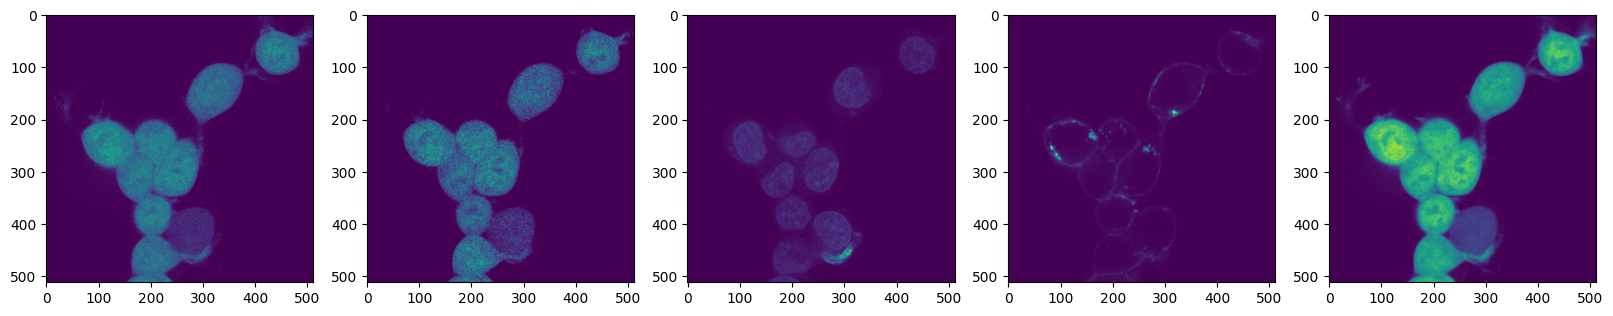

In [106]:
im_no = 3
fig, axs = plt.subplots(1, scene_data.shape[1], figsize=(4*scene_data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(scene_data[im_no,i])

1: nuclei  
2: norm(A) + norm(D)  
3: actin  
4: norm(A) + norm(D) + 2 * norm(actin)  
5: norm(A) + norm(D) - 2 * norm(actin)  

In [107]:
def normalize(img, percentages=(1,99)):
    percentiles = np.percentile(img, percentages)
    out = (img.astype(float) - percentiles[0]) / (percentiles[1] - percentiles[0])
    return out
def combine(cyx_img):
    img_nuc = cyx_img[2]
    img_A = cyx_img[0]
    img_D = cyx_img[1]
    img_act = cyx_img[3]
    img_A_norm = normalize(img_A)
    img_D_norm = normalize(img_D)
    img_act_norm = normalize(img_act)
    return np.stack([
        normalize(img_nuc),
        normalize(img_A_norm + img_D_norm),
        normalize(img_act),
        normalize(img_A_norm + img_D_norm + 2*img_act_norm),
        img_A_norm + img_D_norm - 2*img_act_norm,
    ], axis=0)

In [108]:
scene_data_comp = scene_data.compute()

In [109]:
data = np.stack([combine(cyx_img) for cyx_img in scene_data_comp], axis=0)

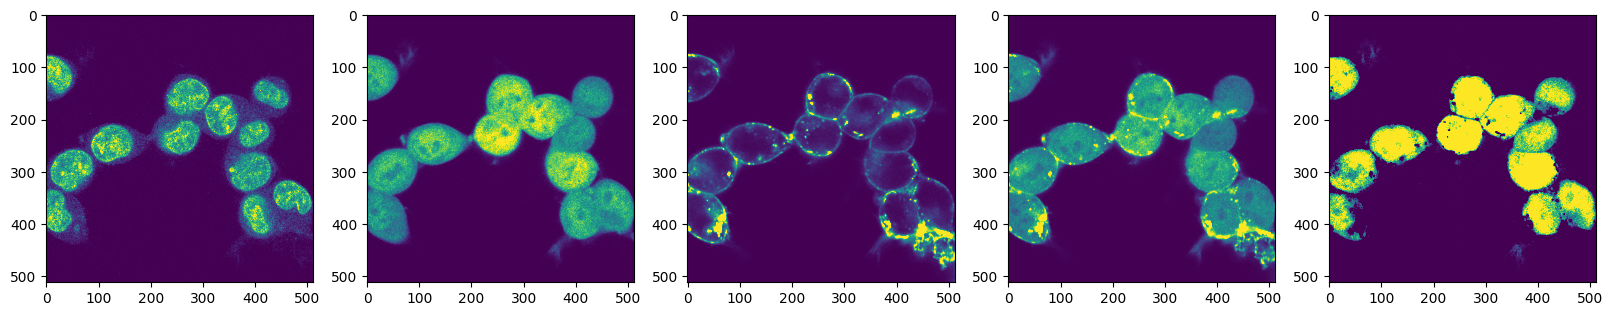

In [110]:
im_no = 0
fig, axs = plt.subplots(1, data.shape[1], figsize=(4*data.shape[1],4))
for i, ax in enumerate(axs):
    ax.imshow(data[im_no,i], vmin=0, vmax=1)

## cellpose

In [111]:
%%time
data_cp = [im for im in data]

CPU times: total: 0 ns
Wall time: 0 ns


### nuclei

In [112]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 11 s
Wall time: 10.7 s


### cells

#### A+D

In [113]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_2 = np.stack(masks_cell)

CPU times: total: 11.6 s
Wall time: 11.1 s


#### actin

In [114]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[3,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_3 = np.stack(masks_cell)

CPU times: total: 11.7 s
Wall time: 11.2 s


#### A + D + 2*actin

In [115]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[4,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_4 = np.stack(masks_cell)

CPU times: total: 11.6 s
Wall time: 11 s


#### A + D - 2*actin

In [116]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[5,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell_5 = np.stack(masks_cell)

CPU times: total: 11.5 s
Wall time: 11 s


In [117]:
viewer = napari.Viewer()
viewer.add_image(data, channel_axis = 1, contrast_limits=[0,1])
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell_2)
viewer.add_labels(masks_cell_3)
viewer.add_labels(masks_cell_4)
viewer.add_labels(masks_cell_5)

<Labels layer 'masks_cell_5' at 0x1e7a6f29650>

Results:  
Overall good segmentation  
Actin sometimes helps, but only slightly